## Robust plan

In [1]:
using JuMP, Gurobi, Plots, LinearAlgebra
GRB_ENV = Gurobi.Env();

Academic license - for non-commercial use only


### Create model for dynamics

In [242]:
dt = 0.1
A = zeros(4,4)+I
A[1,2] = A[3,4] = dt
B = zeros(4,2)
B[2,1] = B[4,2] = dt
C = zeros(2,4)
C[1,2] = C[2,4] = 1
D = zeros(2,2)
Bw = copy(B);

### Create model

In [288]:
T = 0.9
N = Int(T/dt);
x0 = [0;0;0;0]
xN = [0.03;0;0.035;0]
ϵ = [0.01;
     0.003;
     0.01;
     0.003];
    # how close to the goal we want to get

In [289]:
N # Size of time step variables

9

## Obstacles

In [290]:
P = [-1 0; 0 1]
q = [-0.015; 0.03] 
m = length(q)
obj = [[1,2]] # Each entry corresponds to the lines defining an object
Nobj = length(obj)
M = 100; #Big M

## Helper vars

In [384]:
Q = zeros(2,4)
Q[1,1] = Q[2,3] = -1
N_K = Int((N-2)*(N-1)/2) # number of K's
Ak = zeros(N+1,4,4)
Ak[1,:,:] = zeros(Int, size(A))+I
for i=2:N+1
    Ak[i,:,:] = A*Ak[i-1,:,:]
end
Ai = i -> Ak[i+1,:,:]
accumulate = n -> Int(n*(n+1)/2)
get_cone = (i,j) -> accumulate(i-3)+j;
get_ncone = n -> (i,j) -> accumulate(i-3)+j-accumulate(max(3+n,i)-(3+n));
get_3cone = get_ncone(3)

#896 (generic function with 1 method)

In [409]:
get_ncone(N)(N,N-2)

28

In [413]:
zeros(3,3)*I

3×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [391]:
N_K

28

In [372]:
get_cone(7,1)

11

In [386]:
get_3cone(7,1)

10

In [292]:
N_K

28

In [393]:
for i=3:9
    println([get_3cone(i,j) for j=1:min(i-2,3)])
end

[1]
[2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]
[13, 14, 15]
[16, 17, 18]


In [318]:
get_cone(5,1),get_cone(5,2),get_cone(5,3)

(4, 5, 6)

In [407]:
for k=3:N
    println(k)
    for i=1:min(k-2,3)
        println([(k-j-1,get_3cone(j+1,i)) for j=(i+1):(k-1)])
    end
end

3
[(0, 1)]
4
[(1, 1), (0, 2)]
[(0, 3)]
5
[(2, 1), (1, 2), (0, 4)]
[(1, 3), (0, 5)]
[(0, 6)]
6
[(3, 1), (2, 2), (1, 4), (0, 7)]
[(2, 3), (1, 5), (0, 8)]
[(1, 6), (0, 9)]
7
[(4, 1), (3, 2), (2, 4), (1, 7), (0, 10)]
[(3, 3), (2, 5), (1, 8), (0, 11)]
[(2, 6), (1, 9), (0, 12)]
8
[(5, 1), (4, 2), (3, 4), (2, 7), (1, 10), (0, 13)]
[(4, 3), (3, 5), (2, 8), (1, 11), (0, 14)]
[(3, 6), (2, 9), (1, 12), (0, 15)]
9
[(6, 1), (5, 2), (4, 4), (3, 7), (2, 10), (1, 13), (0, 16)]
[(5, 3), (4, 5), (3, 8), (2, 11), (1, 14), (0, 17)]
[(4, 6), (3, 9), (2, 12), (1, 15), (0, 18)]


## Robustness parameters

In [295]:
ϵ2 = 0.05;
max_wind = 0.01;

In [296]:
ρ = max_wind*sqrt(2*log(1/ϵ2))

0.024477468306808164

In [297]:
x_k_det = (k,α) -> Ai(k-1)*x0+sum(Ai(k-i-2)*B*α[:,i+1] for i=0:k-2)

#721 (generic function with 1 method)

## Model

In [300]:
model = Model(optimizer_with_attributes(
        () -> Gurobi.Optimizer(GRB_ENV), #"OutputFlag" => 0
    ));
@variable(model, K[1:N_K,1:2,1:2])   # Control law linear
@variable(model, α[1:2, 1:N-1])      # Control law constant
@variable(model, au[1:2, 1:N-1] >=0) # Absolute value of u(control)
@variable(model, z[1:N-1, 1:m] >=0, Bin) # Binary vars for obstacles
#@variable(model, minϵ[1:4] >=0)
# Variables for auxiliary second order cones:
@variable(model, t[1:N_K,1:m] >= 0) # (we need one for each halfplane)
@variable(model, s[1:N_K,1:2] >= 0); # (one for each control vector)
@variable(model, r[1:N_K,1:4] >= 0); # (one for each state variable)

In [301]:
@constraint(model, cobj[k=1:N-1, i=1:Nobj],
   sum(z[k,j] for j in obj[i]) == length(obj[i])-1); # Obstacles

## Obstacle free path

In [302]:
# Time step k=2
@constraint(model, (P*Q*x_k_det(2,α)
        +ρ*mapslices(norm, P*Q*Bw, dims=2)[:]
        ) .<= -q+M*z[1,:]);
# Time steps k=3 to N:
@constraint(model, [k=3:N], (P*Q*x_k_det(k,α)
        +sum(ρ*t[get_cone(k,i),:] for i=1:k-2)
        +ρ*mapslices(norm, P*Q*Bw, dims=2)[:]
        ) .<= -q+M*z[k-1,:]);

### Maximum control

In [303]:
@constraint(model, α[:,1] .<= au[:,1])
@constraint(model, -au[:,1] .<= α[:,1])
@constraint(model, [k=2:N-1], (α[:,k]
    +ρ*sum(s[get_cone(k,i),:] for i=1:k-2) 
    ) .<= au[:,k])
@constraint(model, [k=2:N-1],  (-α[:,k]
    +ρ*sum(s[get_cone(k,i),:] for i=1:k-2) 
    ) .<= au[:,k]);

### Goals

In [304]:
@constraint(model, (x_k_det(N,α)
        +sum(ρ*r[get_cone(N,i),:] for i=1:N-2)
        +ρ*mapslices(norm, Bw, dims=2)[:]
        ) .<= xN+ϵ);
@constraint(model, (-x_k_det(N,α)
        +sum(ρ*r[get_cone(N,i),:] for i=1:N-2)
        +ρ*mapslices(norm, Bw, dims=2)[:] 
           ) .<= -xN+ϵ);

## Second order constraints

### 1) Obstacles

In [305]:
@constraint(model, [k=3:N,i=1:(k-2),l=1:m], vcat(t[get_cone(k,i),l], (P*Q*Ai(k-i-2)*Bw)[l,:]+sum(
            (P*Q*Ai(k-j-1)*B*K[get_cone(j,i),:,:])[l,:] for j=(i+1):(k-1))) in SecondOrderCone());

In [ ]:
@constraint(model, [k=3:N,i=1:min(k-2,3),l=1:m], vcat(t[get_3cone(k,i),l], (P*Q*Ai(k-i-2)*Bw)[l,:]+sum(
            (P*Q*Ai(k-j-1)*B*K[get_3cone(j,i),:,:])[l,:] for j=(i+1):(k-1))) in SecondOrderCone());

In [329]:
for i=3:3
    println("h")
end

h


In [ ]:
@constraint(model, [k=3:N], (P*Q*x_k_det(k,α)
        +ρ*mapslices(norm, sum(P*Q*Ai(k-i-2)*Bw)[l,:] for i=4:k-2, dims=2)[:]
        +sum(ρ*t[get_3cone(k,i),:] for i=1:min(k-2,3))
        +ρ*mapslices(norm, P*Q*Bw, dims=2)[:]
        ) .<= -q+M*z[k-1,:]);

### 2) Control

In [306]:
@constraint(model, [k=3:N-1,i=1:(k-2),l=1:2], vcat(s[get_cone(k,i),l], sum(
            K[get_cone(j,i),l,:] for j=(i+1):(k-1))) in SecondOrderCone());

### 3) Goals

In [307]:
@constraint(model, [k=3:N,i=1:(k-2),l=1:4], vcat(r[get_cone(k,i),l], (Ai(k-i-2)*Bw)[l,:]+sum(
            (Ai(k-j-1)*B*K[get_cone(j,i),:,:])[l,:] for j=(i+1):(k-1))) in SecondOrderCone());

### Objective

In [308]:
@objective(model, Min, sum(au));

## Optimize

In [309]:
optimize!(model)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 658 rows, 978 columns and 2100 nonzeros
Model fingerprint: 0xa2728fe1
Model has 210 quadratic constraints
Variable types: 962 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+00]
Presolve removed 446 rows and 547 columns
Presolve time: 0.05s
Presolved: 722 rows, 941 columns, 1889 nonzeros
Presolved model has 170 quadratic constraint(s)
Variable types: 934 continuous, 7 integer (7 binary)
Presolve removed 198 rows and 198 columns
Presolve time: 0.07s
Presolved: 524 rows, 743 columns, 1569 nonzeros
Presolved model has 170 second-order cone constraints
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 110
 AA' NZ     : 4.106e+03
 Factor NZ  : 1.121e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.335e+05 (less than

In [284]:
#value.(minϵ)

In [285]:
rectangle(w, h, x, y) = Shape(ones(4)*x + [0,w,w,0], ones(4)*y + [0,0,h,h])

rectangle (generic function with 1 method)

In [310]:
K_out = value.(K)
α_out = value.(α)
s_out = value.(s)
au_out = value.(au)
iterations = 100
Γ = 1
xs2 = zeros(iterations, N)
ys2 = zeros(iterations, N)
for i = 1:iterations
    w = Γ * ρ * randn(2, N - 1)
    y = zeros(4, N)
    y[:, 1] = x0
    for j = 2:N
        u = α_out[:, j - 1]
        for k = 1:j-2
                #u += ρ*s_out[get_cone(j,k),:] 
                u += K_out[get_cone(j, k), :, :]*w[:, k]
        end
        y[:,j] = A*y[:, j-1] + Bw*w[:, j-1] + B*u
    end
    xs2[i, :] = y[1,:]
    ys2[i, :] = y[3,:];
end

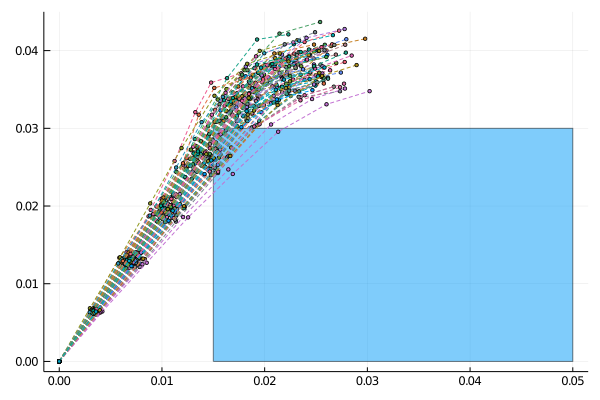

In [311]:
plot(rectangle(0.035,0.03,0.015,0), opacity=.5, legend=:none)
plot!(xs2[:,:]', ys2[:,:]', linestyle=:dash, markershape=:circle, ms=2)